## 探索性分析

数据是3W大众点评八大热门糖水店的评论，包含字段：顾客id、评论时间、评分、评论内容、口味、环境、服务、店铺ID

In [36]:
#引入库
import pandas as pd
from matplotlib import pyplot as plt
import pymysql
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

### 数据库读入数据

我们使用pymysql库连接mysql数据库，pd.read_sql函数直接通过连接读取数据库数据

In [37]:
#连接数据库，读入数据
db = pymysql.connect("localhost",'root','','TESTDB') #服务器：localhost，用户名：root，密码：(空)，数据库：TESTDB
sql = "select * from dzdp;"
data = pd.read_sql(sql,db)
db.close()

### 数据概要

查看数据大小以及基础信息

In [38]:
data.shape

(32483, 8)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32483 entries, 0 to 32482
Data columns (total 8 columns):
cus_id          32483 non-null object
comment_time    32483 non-null object
comment_star    32483 non-null object
cus_comment     32483 non-null object
kouwei          32483 non-null object
huanjing        32483 non-null object
fuwu            32483 non-null object
shopID          32483 non-null object
dtypes: object(8)
memory usage: 2.0+ MB


In [40]:
data.head()

,cus_id,comment_time,comment_star,cus_comment,kouwei,huanjing,fuwu,shopID
0,迷糊泰迪,2018-09-20 06:48,sml-str40,南信 算是 广州 著名 甜品店吧 ，好几个 时间段 路过 ，都是 座无虚席。 看着 餐单 ...,非常好,好,好,518986
1,稱霸幼稚園,2018-09-22 21:49,sml-str40,中午吃完了所谓的早茶 回去放下行李 休息了会 就来吃下午茶了[服务]两层楼 楼下只能收现金...,很好,很好,很好,518986
2,爱吃的美美侠,2018-09-22 22:16,sml-str40,【VIP冲刺王者战队】【吃遍蓉城战队】【VIP有特权】五月份和好朋友毕业旅行来了广州。我们都...,很好,很好,很好,518986
3,姜姜会吃胖,2018-09-19 06:36,sml-str40,都说来广州吃糖水就要来南信招牌姜撞奶，红豆双皮奶牛三星，云吞面一楼现金，二楼微信支付宝位置不...,非常好,很好,很好,518986
4,forevercage,2018-08-24 17:58,sml-str50,一直很期待也最爱吃甜品，广州的甜品很丰富很多样，来之前就一直想着一定要过来吃到腻，今天总算实...,非常好,很好,很好,518986


查看标签列'comment_star'的情况，并进行处理标签数据

In [41]:
#查看情况
data['comment_star'].value_counts()

sml-str40    10849
sml-str50     9067
NAN           5636
sml-str30     5152
sml-str20      982
sml-str10      796
sml-str1         1
Name: comment_star, dtype: int64

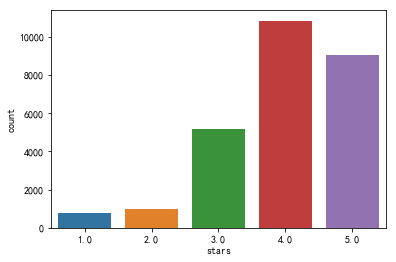

In [42]:
#数据清洗
data.loc[data['comment_star'] == 'sml-str1','comment_star'] = 'sml-str10'
data['stars'] = data['comment_star'].str.findall(r'\d+').str.get(0)
data['stars'] = data['stars'].astype(float)/10
sns.countplot(data=data,x='stars')

可以看出好评和差评的分布并不平衡，好评占比大大高于差评，其中4分评价最高

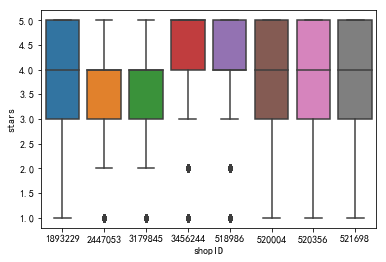

In [43]:
sns.boxplot(data=data,x='shopID',y='stars')

可以看出各家店铺的评价分布不尽相同，但都有一个特点，评分都集中在好评和中评上

## 数据预处理
### 时间特征提取

我们可以从时间中提取到年、月、日、星期、小时等常见特征

In [44]:
data.comment_time = pd.to_datetime(data.comment_time.str.findall(r'\d{4}-\d{2}-\d{2} .+').str.get(0))
data['year'] = data.comment_time.dt.year
data['month'] = data.comment_time.dt.month
data['weekday'] = data.comment_time.dt.weekday
data['hour'] = data.comment_time.dt.hour

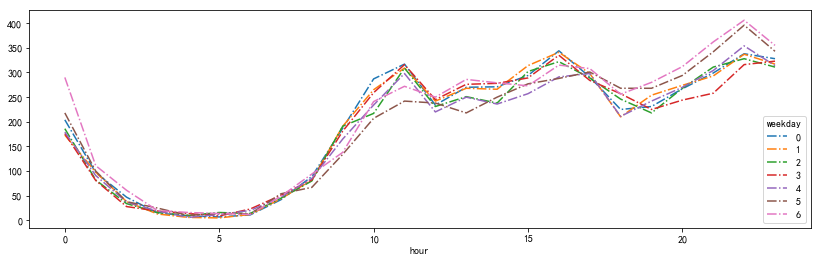

In [45]:
#各星期的小时评论数分布图
fig1, ax1=plt.subplots(figsize=(14,4))
df=data.groupby(['hour', 'weekday']).count()['cus_id'].unstack()
df.plot(ax=ax1, style='-.')
plt.show()

周一到周日的小时评论分布较为类似，评论的高峰出现在，中午11点、下午4点以及晚上10点，周六晚活跃的用户更多，可能是第二天可以睡懒觉的缘故，哈

(0, 600)

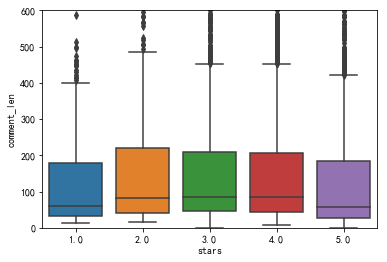

In [46]:
#评论的长短可以看出评论者的认真程度
data['comment_len'] = data['cus_comment'].str.len()
fig2, ax2=plt.subplots()
sns.boxplot(x='stars',y='comment_len',data=data, ax=ax2)
ax2.set_ylim(0,600)

可以看出1分、5分的的评论长度更短，看来短一点的评论才更有力度

### 文本数据预处理

1.**去除非文本数据：**可以看出，爬虫获取的数据非常多类似“\xa0”的非文本数据，而且都还有一些无意义的干扰数据，如结尾的“收起评论”

In [47]:
data['cus_comment'][5]

'甜品一直是我的心头肉，既然来了广州，不吃甜品是不会罢休的\xa0，可惜还有好几家没有办法前往。南信牛奶甜品专家，是非常火的甜品店，一万多条的评论就能看出之火爆，\xa0到店是中午12\xa0点左右，基本是爆满，还好三楼的时候刚好有一桌起来了，不然还真要站着等一会。先点单付钱入座等待红豆双皮奶\xa015\xa0元/\xa0份，等待时长大概\xa015分钟\xa0，食客实在太多了\xa0，可选择冰热，夏天当然要吃冰的\xa0！！吃的有点小恶心，又或者是自己吃不惯\xa0…\xa0挺奇怪的杨枝甘露\xa020元\xa0/\xa0份，这家的杨枝甘露很稀，感觉没啥味道，料很少。。游客店\xa0…\xa0随随便便了人均大概\xa020-30\n                            \n\n\t\t                            收起评论'

In [48]:
#除去非文本数据和无意义文本
data['cus_comment'] = data['cus_comment'].str.replace(r'[^\u4e00-\u9fa5]','').str.replace('收起评论','')

2.**中文分词：**中文文本数据处理，怎么能离开中文分词呢，我们使用jieba库，简单又好用。这里我们把文本字符串处理为以空格区隔的分词字符串

In [49]:
#中文分词
data['cus_comment'] = data['cus_comment'].apply(lambda x:' '.join(jieba.cut(x)))
data['cus_comment'].head()

0    南信 算是 广州 著名 甜品店 吧 好几个 时间段 路过 都 是 座无虚席 看着 餐单 上 ...
1    中午 吃 完 了 所谓 的 早茶 回去 放下 行李 休息 了 会 就 来 吃 下午茶 了 服...
2    冲刺 王者 战队 吃遍 蓉城 战队 有 特权 五月份 和 好 朋友 毕业 旅行 来 了 广州...
3    都 说来 广州 吃 糖水 就要 来南信 招牌 姜撞奶 红豆 双皮奶 牛 三星 云吞面 一楼 ...
4    一直 很 期待 也 最 爱 吃 甜品 广州 的 甜品 很 丰富 很 多样 来 之前 就 一直...
Name: cus_comment, dtype: object

3.**去除停用词：**文本中有很多无效的词，比如“着”，“和”，还有一些标点符号，这些我们不想在文本分析的时候引入，因此需要去掉，因为wordcloud和TF-IDF都支持停用词，因此就不额外处理了


### 词云展示

In [50]:
from wordcloud import WordCloud, STOPWORDS #导入模块worldcloud
from PIL import Image #导入模块PIL(Python Imaging Library)图像处理库
import numpy as np #导入模块numpy，多维数组
import matplotlib.pyplot as plt #导入模块matplotlib，作图
import jieba
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']#作图的中文
matplotlib.rcParams['font.serif'] = ['KaiTi']#作图的中文

infile = open("stopwords.txt",encoding='utf-8')
stopwords_lst = infile.readlines()
STOPWORDS = [x.strip() for x in stopwords_lst]
stopwords = set(STOPWORDS) #设置停用词

In [51]:
def ciyun(shop_ID='all'):
    
    texts = data['cus_comment']
    
    if shop_ID == 'all':
        text = ' '.join(texts)
    else:
        text = ' '.join(texts[data['shopID']==shop_ID])
    
    wc = WordCloud(font_path="msyh.ttc",background_color = 'white',max_words = 100,stopwords = stopwords,
                   max_font_size = 80,random_state =42,margin=3) #配置词云参数
    wc.generate(text) #生成词云
    plt.imshow(wc,interpolation="bilinear")#作图
    plt.axis("off") #不显示坐标轴

In [52]:
data['shopID'].unique()

array(['518986', '520004', '1893229', '520356', '3456244', '3179845',
       '2447053', '521698'], dtype=object)

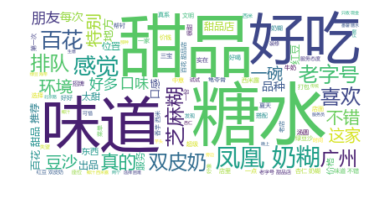

In [53]:
ciyun('520004')

In [54]:
#导出数据
data.to_csv('data.csv',index=False)